# PIT Quasi static forces from spiral model test (nonlinear)

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#import src.models.nonlinear_vmm  as vmm  # Note!
#import src.nonlinear_vmm_equations as eq  # Note!
import src.models.nonlinear_martin_vmm  as vmm  # Note!
import src.nonlinear_martin_vmm_equations as eq  # Note!


#import src.models.linear_vmm as model
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

## Y:

In [2]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

where $Y_{qs}$ is the quasi static force that can be obtained from the model tests as:

In [4]:
Y_eq = eq.Y_eom.subs(eq.Y_nonlin,sp.solve(eq.fy_eq,Y_nonlin)[0])
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [5]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(Y_eq, Y_qs)[0])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [6]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

## X:

In [7]:
X_eq = eq.X_eom.subs(eq.X_nonlin,sp.solve(eq.fx_eq,X_nonlin)[0])

eq_X_qs = sp.Eq(X_qs,
      sp.solve(X_eq, X_qs)[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [8]:
X_qs_lambda = lambdify(eq_X_qs.subs(subs).rhs)

## N:

In [9]:
N_eq = eq.N_eom.subs(eq.N_nonlin,sp.solve(eq.mz_eq,N_nonlin)[0])

eq_N_qs = sp.Eq(N_qs,
      sp.solve(N_eq, N_qs)[0])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

In [10]:
N_qs_lambda = lambdify(eq_N_qs.subs(subs).rhs)

# Quasi static forces from model tests

## Load test

In [11]:
df_runs = mdl.runs()

In [12]:
df_runs_selected = df_runs.groupby(by='test_type').get_group('rodergrundvinkel')

In [13]:
def load_run(id):
    
    df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
    df.index = df.index.total_seconds()
    df = df.iloc[1500:-100].copy()
    df.index-=df.index[0]
    df.sort_index(inplace=True)
    df['-delta'] = -df['delta']
    df['V'] = np.sqrt(df['u']**2 + df['v']**2)
    return df, units, meta_data

In [14]:
df = pd.DataFrame()
for id, _ in df_runs_selected.iterrows():
    
    df_,units, meta_data = load_run(id=id)
    df_['id'] = id
    df_['t'] = df_.index
    df = df.append(df_, ignore_index=True)
    

In [15]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
beam                                                             0.946602
comment                                                  Rodergrundvinkel
date                                                           2020-09-22
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\001\0...
gm                                                               0.136092
kg                                                               0.438908
lcg                                   

In [16]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta,V,id,t
0,0.0,1.0,1.550702,1.550863,0.707800,26.397204,1.708627,78.630802,1.0,0.891904,0.891913,-0.243083,26.397204,3.879334,82.680682,0.007557,-0.021825,-0.062482,-0.022542,-0.010069,0.016267,9.598900,5.392061,-0.132701,9.539582,5.439737,0.111214,0.000765,0.645772,14.89,-0.959931,0.000025,0.002852,0.000098,-0.038834,19.905762,-0.166187,0.002630,0.425136,-0.052977,-0.000030,-0.174699,-0.004366,19.904251,0.953834,-0.000153,-0.165973,-0.024921,-0.002359,-0.038804,-0.002785,0.000038,0.954082,0.012101,-0.000030,-0.000061,-0.002363,-0.174699,-0.002785,0.000038,-0.012683,-0.000765,0.954159,22612,0.000000
1,0.0,1.0,1.550689,1.550863,0.832092,26.397204,0.049076,78.629750,1.0,0.891904,0.891913,-0.276007,26.397204,4.979269,82.678395,-0.014367,0.003961,-0.049576,-0.026407,0.009273,0.035600,9.614405,5.496306,-0.133718,9.558165,5.357585,0.111053,0.003258,0.645772,14.89,-0.959931,0.000025,0.002857,0.000198,-0.038834,19.905737,-0.166273,0.002655,0.977827,-0.007614,0.000051,0.016388,0.000000,19.910451,0.955463,-0.000790,-0.166199,-0.024655,-0.002361,-0.038822,-0.002734,0.000041,0.955700,0.012447,0.000051,-0.000697,-0.002390,0.016388,-0.002734,0.000041,-0.013024,-0.003258,0.955781,22612,0.010014
2,0.0,1.0,1.550702,1.550863,0.643086,26.397204,1.940192,78.629750,1.0,0.891904,0.891913,0.002907,26.397204,3.146044,82.678395,0.008202,-0.030850,-0.041187,0.023197,0.025390,0.008533,9.589383,5.617060,-0.131783,9.496586,5.334502,0.112409,0.006707,0.645772,14.89,-0.959931,0.000025,0.002957,0.000102,-0.038834,19.925255,-0.166339,0.002632,1.476426,-0.004833,0.000298,-0.012717,0.004355,19.923492,0.956957,-0.000152,-0.166313,-0.024494,-0.002341,-0.038824,-0.002706,0.000048,0.957187,0.012668,0.000298,-0.000061,-0.002345,-0.012717,-0.002706,0.000048,-0.013234,-0.006707,0.957270,22612,0.019997
3,0.0,1.0,1.550723,1.550792,0.333526,26.398565,1.361279,78.629750,1.0,0.891904,0.891911,0.408881,26.398565,1.042659,82.678395,0.040442,-0.072107,-0.032152,0.033505,-0.005556,-0.046244,9.575627,5.726926,-0.127613,9.522613,5.358169,0.114567,0.010340,0.645772,14.89,-0.959931,0.000025,0.002912,0.000223,-0.038746,19.935228,-0.166369,0.002661,0.949507,-0.004254,-0.000205,0.006840,-0.004366,19.933983,0.956133,0.000013,-0.166389,-0.024535,-0.002312,-0.038811,-0.002722,0.000058,0.956365,0.012583,-0.000205,0.000102,-0.002310,0.006840,-0.002722,0.000058,-0.013156,-0.010340,0.956448,22612,0.030004
4,0.0,1.0,1.550716,1.550935,0.223303,26.395842,1.206902,78.630802,1.0,0.891911,0.891915,0.592257,26.395842,4.786298,82.680682,0.010781,-0.017312,-0.011502,0.028995,0.036995,0.026578,9.497092,5.778784,-0.122480,9.541165,5.413140,0.116733,0.009602,0.645772,14.89,-0.959931,0.000025,0.002870,0.000086,-0.038921,19.944255,-0.166424,0.002627,0.454316,-0.004847,0.000434,-0.003581,-0.013079,19.942663,0.955298,-0.000155,-0.166496,-0.024784,-0.002288,-0.038894,-0.002726,0.000048,0.955540,0.012381,0.000434,-0.000066,-0.002292,-0.003581,-0.002726,0.000048,-0.012956,-0.009602,0.955620,22612,0.040007


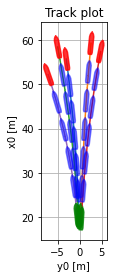

In [17]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
for id,group in df.groupby(by='id'):
    track_plot(df=group, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [18]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

In [19]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

# Brix parameters

In [20]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters['brix_prime'].fillna(0, inplace=True)

In [21]:
df_parameters['brix_prime']

Xudot               0.000179
Xvdot               0.000000
Xrdot               0.000000
Yudot               0.000000
Yvdot              -0.006109
Yrdot              -0.000303
Nudot               0.000000
Nvdot              -0.000128
Nrdot              -0.000299
Xu                  0.000000
Xv                  0.000000
Xr                  0.000000
Xdelta              0.000000
Xuu                 0.000000
Xuv                 0.000000
Xur                 0.000000
Xudelta             0.000000
Xvv                 0.000000
Xvr                 0.000000
Xvdelta             0.000000
Xrr                 0.000000
Xrdelta             0.000000
Xdeltadelta         0.000000
Xuuu                0.000000
Xuuv                0.000000
Xuur                0.000000
Xuudelta            0.000000
Xuvv                0.000000
Xuvr                0.000000
Xuvdelta            0.000000
Xurr                0.000000
Xurdelta            0.000000
Xudeltadelta        0.000000
Xvvv                0.000000
Xvvr          

# Model test to prime system

In [22]:
interesting = [
    'u',
    'v',
    'r',
    'u1d',
    'v1d',
    'r1d',
    'delta',
    'x0',
    'y0',
    'psi',
    'id',
    't',
]
df_prime = ps.prime(df[interesting], U=df['V'])

In [23]:
df_prime['Y_qs'] = run(Y_qs_lambda, inputs= ps.prime(ship_parameters), **df_prime, **df_parameters['brix_prime'])
df_prime['X_qs'] = run(X_qs_lambda, inputs= ps.prime(ship_parameters), **df_prime, **df_parameters['brix_prime'])
df_prime['N_qs'] = run(N_qs_lambda, inputs=ps.prime(ship_parameters), **df_prime, **df_parameters['brix_prime'])

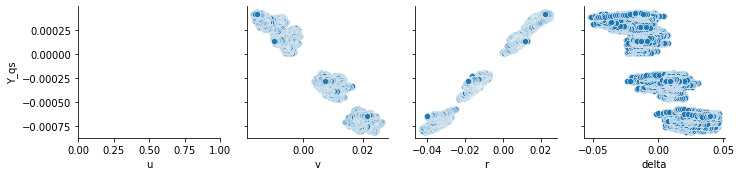

In [24]:
g = sns.PairGrid(df_prime, x_vars=['u','v','r','delta'], y_vars=['Y_qs'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

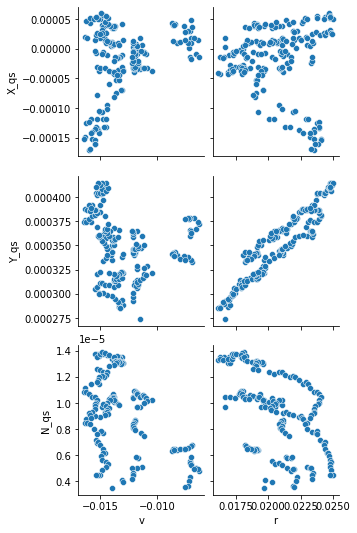

In [25]:
mask = df_prime['delta'] <= df_prime['delta'].quantile(q=0.01)
df_min = df_prime.loc[mask].copy()
sns.pairplot(df_min, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:>

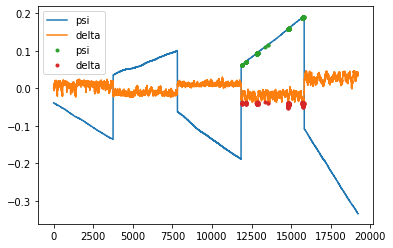

In [26]:
fig,ax=plt.subplots()
df_prime.plot(y=['psi','delta'], ax=ax)
df_min.plot(y=['psi','delta'], style='.', ax=ax)

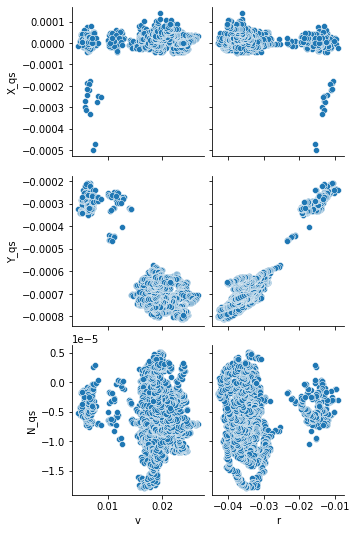

In [27]:
mask = df['delta'] >= df['delta'].quantile(q=0.85)
df_max = df_prime.loc[mask].copy()
sns.pairplot(df_max, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:>

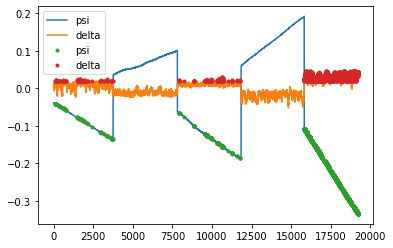

In [28]:
fig,ax=plt.subplots()
df.plot(y=['psi','delta'], ax=ax)
df_max.plot(y=['psi','delta'], style='.', ax=ax)

# Regression

## N

In [29]:
Math(vlatex(eq.N_qs_eq))

<IPython.core.display.Math object>

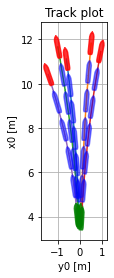

In [30]:
fig,ax=plt.subplots()
ship_parameters_prime = ps.prime(ship_parameters)

for id,group in df_prime.groupby(by='id'):
    track_plot(df=group, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'], 
               x_dataset='x0', y_dataset='y0',  psi_dataset='psi', ax=ax);

In [31]:
N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=eq.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

In [32]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[    N_{rr}],
[N_{udelta}],
[ N_{delta}],
[     N_{r}],
[     N_{u}],
[     N_{v}]]))

In [33]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [34]:
diff_eq_N.eq_y

Eq(y, N_)

In [35]:
diff_eq_N.y_lambda

<function _lambdifygenerated(N_)>

In [36]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   N_qs   R-squared (uncentered):                   0.547
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              3865.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:56:18   Log-Likelihood:                      2.1654e+05
No. Observations:               19222   AIC:                                 -4.331e+05
Df Residuals:                   19216   BIC:                                 -4.330e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nrr           -0.0012      0.000     -5.384      0.000      -0.002      -0.001
Nudelta        0.4704      0.033     14.210      0.000       0.406       0.535
Ndelta        -0.4707      0.033    -14.218      0.000      -0.536      -0.406
Nr            -0.0002   1.08e-05    -17.733      0.000      -0.000      -0.000
Nu         -1.345e-06   3.03e-08    -44.413      0.000    -1.4e-06   -1.29e-06
Nv            -0.0002   1.06e-05    -15.630      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       95.826   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.217
Skew:                          -0.158   Prob(JB):                     2.85e-22
Kurtosis:                       3.157   Cond. No.                     2.09e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

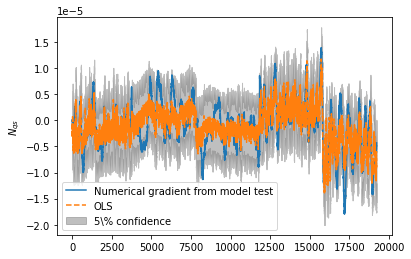

In [37]:
X = diff_eq_N.calculate_features(data=df_prime)
y = diff_eq_N.calculate_label(y=df_prime['N_qs'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N_{qs}$')

## Y

In [38]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=eq.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Y_qs   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          6.335e+05
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:56:18   Log-Likelihood:                      1.7405e+05
No. Observations:               19222   AIC:                                 -3.481e+05
Df Residuals:                   19216   BIC:                                 -3.480e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yvv           -0.1241      0.008    -15.395      0.000      -0.140      -0.108
Yudelta       -7.7926      0.366    -21.301      0.000      -8.510      -7.076
Ydelta         7.7936      0.366     21.305      0.000       7.077       8.511
Yr             0.0183   5.49e-05    333.434      0.000       0.018       0.018
Yu         -1.248e-05   2.75e-07    -45.328      0.000    -1.3e-05   -1.19e-05
Yv            -0.0034      0.000    -25.928      0.000      -0.004      -0.003
==============================================================================
Omnibus:                      146.117   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.767
Skew:                           0.124   Prob(JB):                     1.02e-41
Kurtosis:                       3.417   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

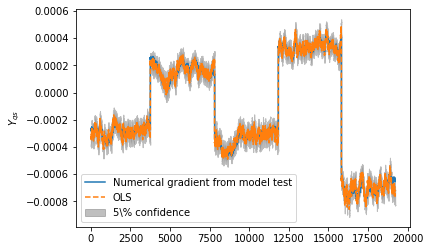

In [39]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = diff_eq_Y.calculate_label(y=df_prime['Y_qs'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y_{qs}$')

## X

In [40]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=eq.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   X_qs   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              78.79
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                    2.06e-66
Time:                        17:56:19   Log-Likelihood:                      1.6004e+05
No. Observations:               19222   AIC:                                 -3.201e+05
Df Residuals:                   19218   BIC:                                 -3.200e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xdeltadelta     0.0035      0.001      2.655      0.008       0.001       0.006
Xvv             0.0630      0.012      5.134      0.000       0.039       0.087
Xvr             0.0084      0.007      1.136      0.256      -0.006       0.023
Xu           -1.01e-05   6.39e-07    -15.807      0.000   -1.14e-05   -8.85e-06
==============================================================================
Omnibus:                    20625.603   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1374603.169
Skew:                          -5.562   Prob(JB):                         0.00
Kurtosis:                      42.907   Cond. No.                     3.35e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

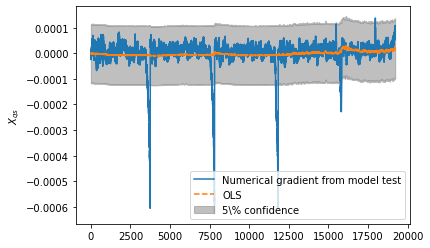

In [41]:
X = diff_eq_X.calculate_features(data=df_prime)
y = diff_eq_X.calculate_label(y=df_prime['X_qs'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X_{qs}$')

In [42]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [43]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [44]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,regressed,coord,dof,state,symbol,prime
Ndelta,1.201447e-45,-0.405784,-0.535553,NaN,0.000000,-0.470669,delta,N,,N_{delta},-0.470669
Ndeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadelta,N,,N_{deltadelta},0.000000
Ndeltadeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadeltadelta,N,,N_{deltadeltadelta},0.000000
Nr,8.322110e-70,-0.000170,-0.000213,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-0.000192,r,N,,N_{r},-0.000192
Nrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdelta,N,,N_{rdelta},0.000000
Nrdeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdeltadelta,N,,N_{rdeltadelta},0.000000
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},-0.000299
Nrr,7.363066e-08,-0.000791,-0.001697,NaN,0.000000,-0.001244,rr,N,,N_{rr},-0.001244
Nrrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rrdelta,N,,N_{rrdelta},0.000000
Nrrr,NaN,NaN,NaN,NaN,0.000000,NaN,rrr,N,,N_{rrr},0.000000


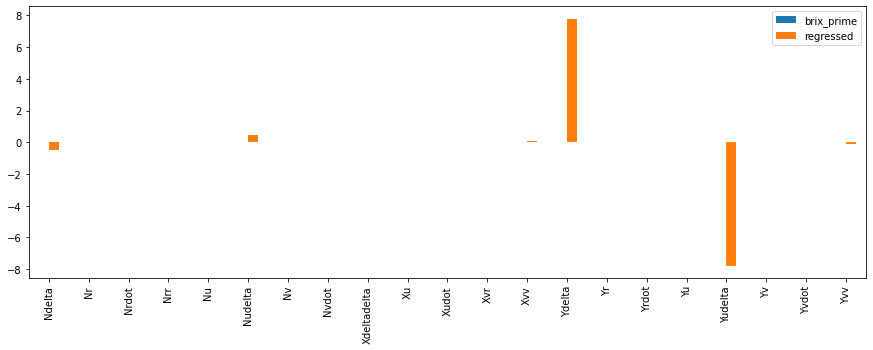

In [45]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
mask = ((df_parameters_all['brix_prime'] != 0) |
        (df_parameters_all['regressed']).notnull())
        
df_parameters_plot = df_parameters_all.loc[mask]
df_parameters_plot.plot.bar(y=['brix_prime','regressed'], ax=ax);

# Simulate captive

In [46]:
X_qs_lambda = lambdify(eq.X_qs_eq.rhs.subs(subs))
Y_qs_lambda = lambdify(eq.Y_qs_eq.rhs.subs(subs))
N_qs_lambda = lambdify(eq.N_qs_eq.rhs.subs(subs))

In [47]:
df_prime['X_qs_pred'] = run(function=X_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['Y_qs_pred'] = run(function=Y_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['N_qs_pred'] = run(function=N_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])


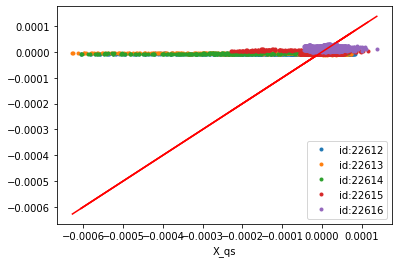

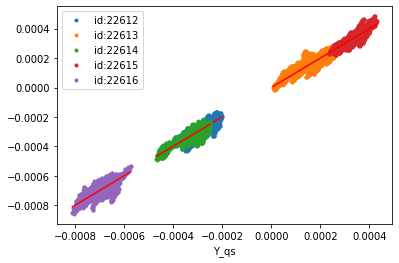

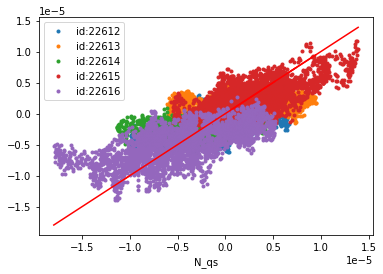

In [48]:
for key in ['X_qs','Y_qs','N_qs']:
    fig,ax=plt.subplots()
    for id,group in df_prime.groupby(by='id'):
        group.plot(x=key, y=f'{key}_pred',style='.', ax=ax, label=f'id:{int(id)}')
        ax.plot([group[key].min(), group[key].max()], [group[key].min(), group[key].max()], 'r-')

# Simulation

In [49]:
def simulate(df_):

    control = df_[['delta']]
    #control = {'delta':0,}
    
    df_0 = df_.iloc[0:100].median(axis=0)
    y0 = {
        'u' : df_0['u'], 
        'v' : df_0['v'],
        'r' : df_0['r'],
        'x0' : df_0['x0'],
        'y0' : df_0['y0'],
        'psi' : df_0['psi'],
        }
    
    #solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
    simulation = vmm.NonLinearSimulation()
    
    t = np.linspace(df_.index.min(),df_.index.max(),len(df_))
    t_span = [t[0],t[-1]]
    
    parameters_prime = dict(df_parameters_all['prime'])
    ship_parameters_prime = ps.prime(ship_parameters)
    
    control_prime = control
    
    solution = solve_ivp(fun=simulation.step, t_span=t_span, y0=list(y0.values()), t_eval=t, 
        args=(parameters_prime, ship_parameters_prime, control_prime,))
    
    columns = list(y0.keys())
    df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
    df_result_prime.index=t[0:len(df_result_prime)]
        
    return df_result_prime


In [50]:
df_result = pd.DataFrame()
for id,group in df_prime.groupby(by='id'):
    
    df_ = group.set_index('t')
    df_result_ = simulate(df_)
    df_result_['id'] = id
    df_result_['t'] = df_result_.index
    df_result = df_result.append(df_result_, ignore_index=True)
    

In [51]:
df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])
df_prime['beta'] = -np.arctan2(df_prime['v'],df_prime['u'])

KeyError: 'beta'

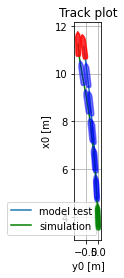

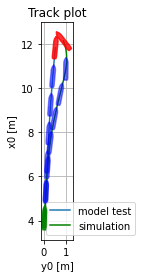

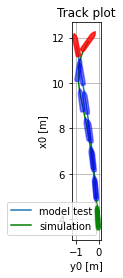

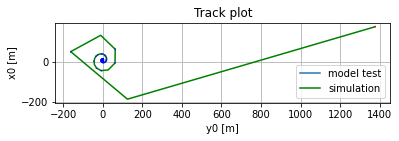

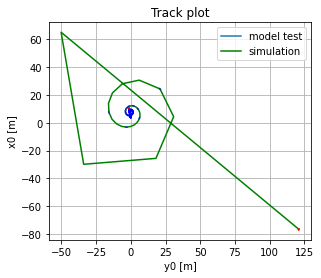

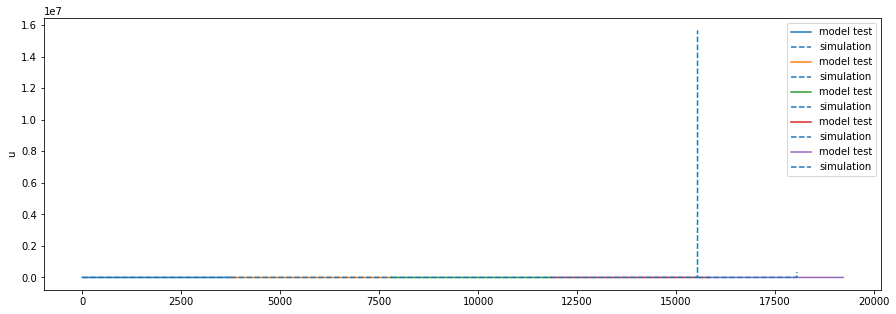

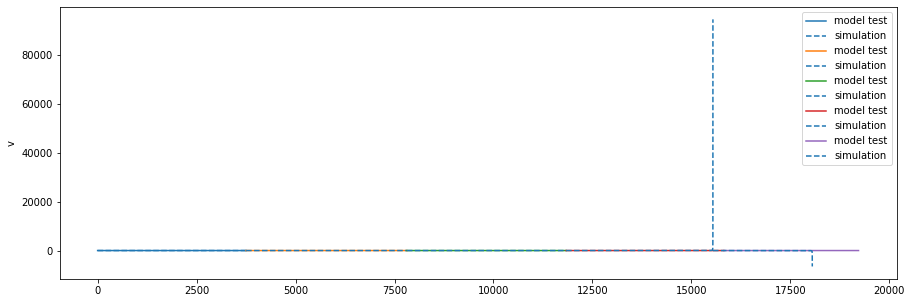

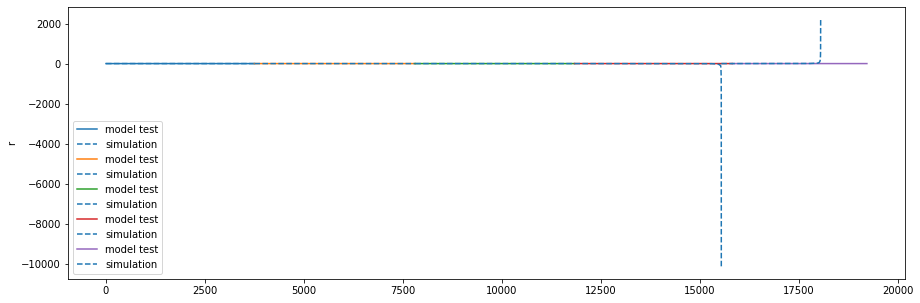

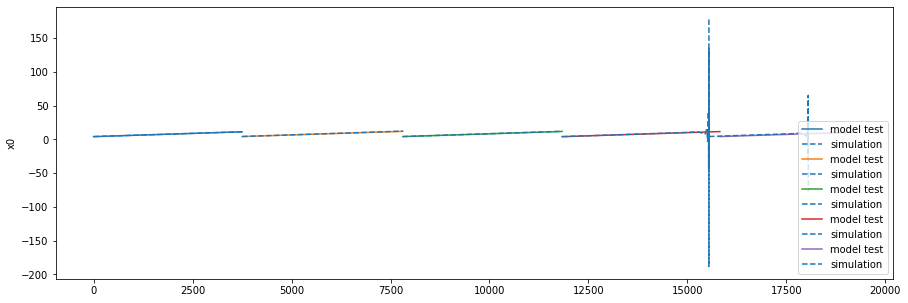

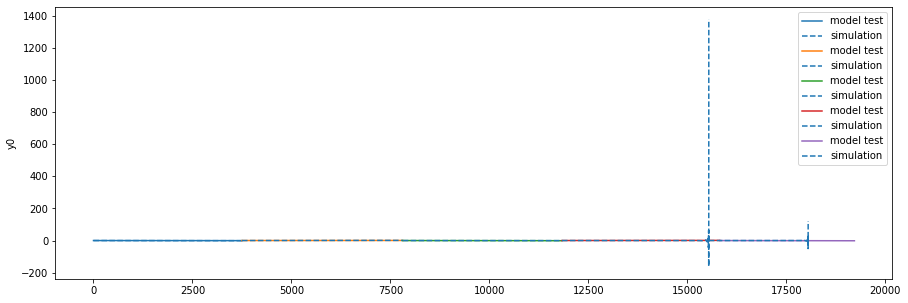

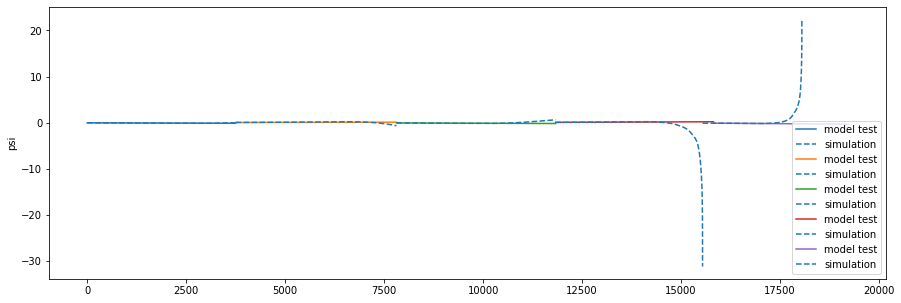

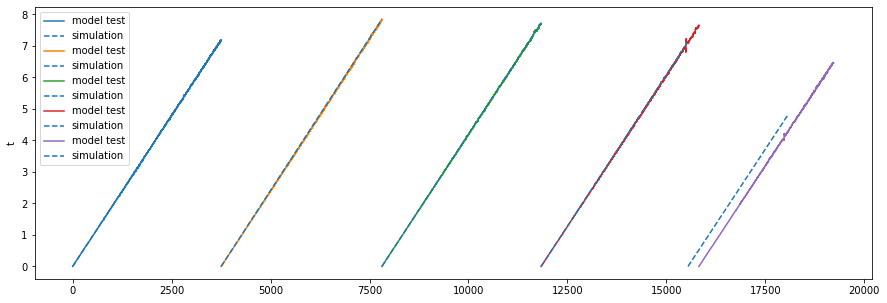

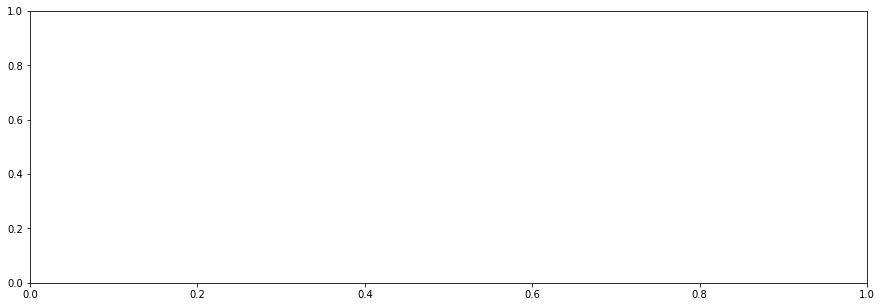

In [52]:
groups = df_prime.groupby(by='id')
for id,group in df_result.groupby(by='id'):
    fig,ax=plt.subplots()
    track_plot(df=groups.get_group(id), lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
    track_plot(df=group, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
    ax.legend()

for key in df_result:
    
    if key=='id':
        continue
    
    fig,ax = plt.subplots()
    fig.set_size_inches(15,5)
        
    for id,group in df_result.groupby(by='id'):
        plot = groups.get_group(id).plot(y=key, label='model test', ax=ax)
        
        color = plot.lines[0].get_color()
        group.plot(y=key, label='simulation', color=color, style='--', ax=ax)
        ax.set_ylabel(key)

